<a href="https://colab.research.google.com/github/kkipngenokoech/MI/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the data

In [1]:
!wget https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip -O smrdata.zip


--2025-11-16 22:11:36--  https://media.githubusercontent.com/media/kkipngenokoech/MI/refs/heads/main/smrdata.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540873695 (1.4G) [application/zip]
Saving to: ‘smrdata.zip’

smrdata.zip         100%[===================>]   1.43G  17.6MB/s    in 88s     

2025-11-16 22:13:05 (16.6 MB/s) - ‘smrdata.zip’ saved [1540873695/1540873695]



In [2]:
!unzip smrdata.zip > /dev/null 2>&1
%cd smrdata


/content/smrdata


## IMPORTS

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

File: Session1/Session1_LRS001R01.mat
Channels (active only): 13 Samples: 185880 fs: 1000


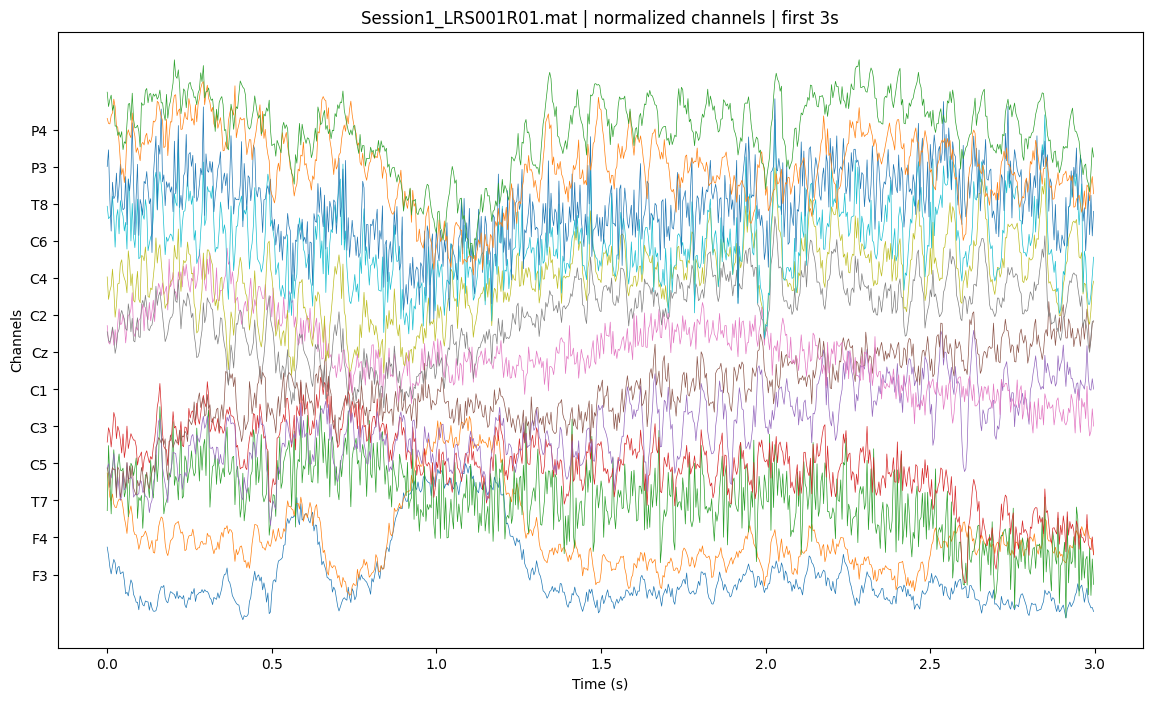

In [4]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os

# ---- CONFIG ----
data_dir = "Session1"        # folder containing the .mat file
vis_seconds = 3              # how many seconds of data to plot
downsample = 4               # plot every Nth sample
offset = 400                 # vertical shift between channels (μV)
# -----------------

# pick the first .mat file automatically
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".mat")])
if not files:
    raise RuntimeError("No .mat files found.")
matfile = os.path.join(data_dir, files[0])

# load
run = sio.loadmat(matfile)["runData"][0, 0]

fs = int(run["fs"][0, 0])             # sampling rate
X = run["allData"]                   # (channels, samples)

# fix labels
labels_array = run["label"]
labels = [str(l[0]) if isinstance(l, np.ndarray) else str(l) for l in labels_array.flatten()]

nch, nsamp = X.shape
assert len(labels) == nch, f"Number of labels ({len(labels)}) does not match number of channels ({nch})"

ts = run["trialStart"].flatten().astype(int)

# ---- determine range first ----
N = min(int(vis_seconds * fs), nsamp)
t = np.arange(N)[::downsample] / fs

# ---- select only active electrodes ----
active_labels = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]
active_idx = [i for i, l in enumerate(labels) if l in active_labels]

# subset data
Y = X[active_idx, :N][:, ::downsample]
labels = [labels[i] for i in active_idx]
nch = len(active_idx)

print("File:", matfile)
print("Channels (active only):", nch, "Samples:", nsamp, "fs:", fs)

# ---- plot normalized, vertically shifted signals ----
plt.figure(figsize=(14, 8))
for i in range(nch):
    y = Y[i]
    y_norm = (y - np.mean(y)) / np.std(y)  # z-score
    plt.plot(t, y_norm + i, linewidth=0.5)  # vertical shift by index

plt.xlabel("Time (s)")
plt.ylabel("Channels")
plt.yticks(range(nch), labels if nch <= 80 else [])
plt.title(f"{files[0]} | normalized channels | first {vis_seconds}s")
plt.show()


## DATA PRE-PROCESSING

In [5]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 96.0 MB/s eta 0:00:00


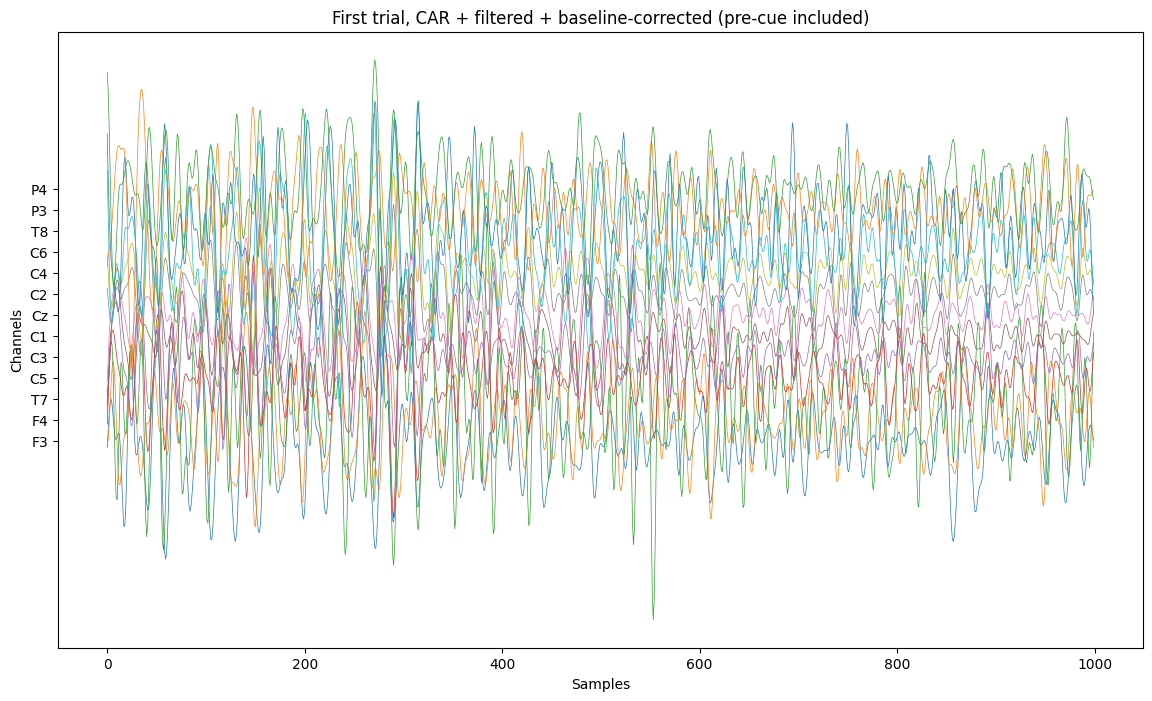

In [6]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os

# ---- CONFIG ----
data_dir = "Session1"
downsample = 4
lowcut = 8
highcut = 30
baseline_window = (-2, 0)    # 2s pre-trialStart
epoch_window = (-2, 2)       # 2s pre + 2s post trialStart

# ---- LOAD DATA ----
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".mat")])
matfile = os.path.join(data_dir, files[0])
run = sio.loadmat(matfile)["runData"][0, 0]

fs = int(run["fs"][0, 0])
X = run["allData"]
labels_array = run["label"]
labels = [str(l[0]) if isinstance(l, np.ndarray) else str(l) for l in labels_array.flatten()]

# ---- SELECT ACTIVE ELECTRODES ----
active_labels = [
    'F3','F4','Fc5','Fc3','Fc1','Fcz','Fc2','Fc4','Fc6',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'Cp5','Cp3','Cp1','Cpz','Cp2','Cp4','Cp6','P3','P4'
]
active_idx = [i for i, l in enumerate(labels) if l in active_labels]
X = X[active_idx, :]
labels = [labels[i] for i in active_idx]
nch = len(active_idx)

# ---- BANDPASS FILTER ----
def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data, axis=1)

X_filt = bandpass(X, lowcut, highcut, fs)

# ---- DOWNSAMPLE ----
X_ds = X_filt[:, ::downsample]
fs_new = fs / downsample

# ---- COMMON AVERAGE REFERENCE ----
X_car = X_ds - X_ds.mean(axis=0, keepdims=True)

# ---- VALID TRIALS ----
outcome = run["outcome"].flatten()
valid_idx = np.where(outcome != 0)[0]

# ---- EPOCH EXTRACTION (pre-cue + post) ----
ts = run["trialStart"].flatten().astype(int)
epoch_samples = int((epoch_window[1]-epoch_window[0])*fs_new)
epochs = []
y_labels = []
for i, s in enumerate(ts):
    if i not in valid_idx:
        continue
    start = int((s/fs + epoch_window[0])*fs_new)
    end = start + epoch_samples
    if start >= 0 and end <= X_car.shape[1]:
        epochs.append(X_car[:, start:end])
        y_labels.append(run["target"].flatten()[i])
epochs = np.stack(epochs, axis=0)
y_labels = np.array(y_labels)
y_dl = y_labels - 1  # convert 1/2 → 0/1 for deep learning

# ---- BASELINE CORRECTION ----
baseline_idx = (int((baseline_window[0]-epoch_window[0])*fs_new),
                int((baseline_window[1]-epoch_window[0])*fs_new))
epochs_baseline = epochs - epochs[:, :, baseline_idx[0]:baseline_idx[1]].mean(axis=2, keepdims=True)

# ---- PLOT FIRST TRIAL ----
plt.figure(figsize=(14,8))
scale = 2.0
for i in range(nch):
    y = epochs_baseline[0, i, :]
    plt.plot(y + i*scale, linewidth=0.5)
plt.yticks([i*scale for i in range(nch)], labels)
plt.xlabel("Samples")
plt.ylabel("Channels")
plt.title("First trial, CAR + filtered + baseline-corrected (pre-cue included)")
plt.show()


## FEATURE EXTRACTION

### Bandpower + LDA

In [8]:
# from scipy.signal import welch
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# def bandpower_epochs(epochs, fs, bands=[(8,12),(13,30)]):
#     n_trials, n_channels, n_samples = epochs.shape
#     features = []
#     for tr in range(n_trials):
#         trial_features = []
#         for ch in range(n_channels):
#             f, Pxx = welch(epochs[tr,ch,:], fs=fs, nperseg=256)
#             for (low, high) in bands:
#                 idx = np.logical_and(f >= low, f <= high)
#                 trial_features.append(Pxx[idx].mean())
#         features.append(trial_features)
#     return np.array(features)

# X_features = bandpower_epochs(epochs_baseline, fs_new)
# y_labels = np.array(run['outcome'].flatten())  # assuming 0/1 for Left/Right MI
# clf = LDA()
# clf.fit(X_features, y_labels)


### Bandpower + SVM

In [9]:
# from sklearn.svm import SVC
# clf_svm = SVC(kernel='linear')
# clf_svm.fit(X_features, y_labels)


### Common Spatial Patterns (CSP) + LDA

In [10]:
# from mne.decoding import CSP

# csp = CSP(n_components=4, reg=None)
# X_csp = csp.fit_transform(epochs_baseline, y_labels)
# clf_csp = LDA()
# clf_csp.fit(X_csp, y_labels)


### deep learning

In [11]:
# # Using Keras / TensorFlow
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout

# model = Sequential([
#     Conv1D(16, kernel_size=64, padding='same', input_shape=(nch, epoch_samples)),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv1D(32, kernel_size=32, padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     GlobalAveragePooling1D(),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(epochs_baseline, y_labels, epochs=50, batch_size=16, validation_split=0.2)


### general pipeline

In [ ]:
import numpy as np
from scipy.signal import welch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from mne.decoding import CSP
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout

# --- Ensure y_labels matches valid trials (remove aborted trials) ---
valid_idx = np.where(run["outcome"].flatten() != 0)[0]
y_labels = run["target"].flatten()[valid_idx]  # original labels: 1/2
epochs_baseline = epochs_baseline[valid_idx, :, :]
n_trials, n_channels, n_samples = epochs_baseline.shape

# --- 1) Bandpower Features ---
def bandpower_epochs(epochs, fs, bands=[(8,12),(13,30)]):
    features = []
    for tr in range(epochs.shape[0]):
        trial_features = []
        for ch in range(epochs.shape[1]):
            f, Pxx = welch(epochs[tr,ch,:], fs=fs, nperseg=256)
            for (low, high) in bands:
                idx = np.logical_and(f >= low, f <= high)
                trial_features.append(Pxx[idx].mean())
        features.append(trial_features)
    return np.array(features)

X_bp = bandpower_epochs(epochs_baseline, fs_new)

# --- 1a) LDA ---
lda = LDA()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score_lda = cross_val_score(lda, X_bp, y_labels, cv=cv)
print("Bandpower + LDA PVC: %.2f%%" % (score_lda.mean()*100))

# --- 1b) SVM ---
svm = SVC(kernel='linear')
score_svm = cross_val_score(svm, X_bp, y_labels, cv=cv)
print("Bandpower + SVM PVC: %.2f%%" % (score_svm.mean()*100))

# --- 2) CSP + LDA ---
csp = CSP(n_components=4, reg=None)
X_csp = csp.fit_transform(epochs_baseline, y_labels)
lda_csp = LDA()
score_csp = cross_val_score(lda_csp, X_csp, y_labels, cv=cv)
print("CSP + LDA PVC: %.2f%%" % (score_csp.mean()*100))

# --- Prepare labels for deep learning (0/1) ---
y_dl = y_labels - 1  # convert 1/2 → 0/1
X_cnn = epochs_baseline.transpose(0,2,1)  # shape: (n_trials, n_samples, n_channels)

# --- 3) 1D CNN ---
cnn_model = Sequential([
    Conv1D(16, kernel_size=64, padding='same', input_shape=(n_samples, n_channels)),
    BatchNormalization(),
    Activation('relu'),
    Conv1D(32, kernel_size=32, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_cnn, y_dl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

cnn_score = cnn_model.evaluate(X_cnn, y_dl, verbose=0)
print("1D CNN PVC: %.2f%%" % (cnn_score[1]*100))

# --- 4) EEGNet-like model ---
def EEGNet(input_shape, n_classes=2):
    model = Sequential([
        Conv1D(16, kernel_size=64, padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        Conv1D(32, kernel_size=32, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    return model

eegnet = EEGNet((n_samples, n_channels))
eegnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
eegnet.fit(X_cnn, y_dl, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
eegnet_score = eegnet.evaluate(X_cnn, y_dl, verbose=0)
print("EEGNet PVC: %.2f%%" % (eegnet_score[1]*100))
